# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to work in pairs.

Answers to many questions may benefit from using more than one cell, as well as a combination of markdown and code cells.

Put helper functions into a separate script (e.g. hwutils.py) so they can be commented on easily and focus the notebook on plotting. Also see the workshop on Clean Code from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.

In [1]:
# useful libraries to import

import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

##hwutils is a separate script where we can put helper functions
#from hwutils import *

In [3]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('/Users/yuqiuwang/Desktop/qbio577_fall2022/data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('/Users/yuqiuwang/Desktop/qbio577_fall2022/data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/_f/pqtw_nqx5pg45m8x8n9w4h4w0000gn/T/ipykernel_32760/4285090326.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('/Users/yuqiuwang/Desktop/qbio577_fall2022/data/ENCODE_GRCh38_bigWig_metadata.tsv')


In [4]:
df

,chrom,start,end,ENCFF230YBR,ENCFF953CVO,ENCFF520IHF,ENCFF730SPR,ENCFF559YWA,ENCFF640PJT,ENCFF919FBG,...,ENCFF418EBS,ENCFF270BHF,ENCFF365EIN,ENCFF321AHD,ENCFF595QZS,ENCFF303MWS,ENCFF907FVJ,ENCFF567WCU,ENCFF423TVA,ENCFF308KWQ
0,chr10,0,10000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,chr10,10000,20000,0.016585,0.141369,0.000000,0.092070,0.048068,0.006080,0.029362,...,0.074162,0.033137,0.105691,0.000000,0.000000,0.045821,0.034791,0.000000,0.000000,0.0
2,chr10,20000,30000,0.000000,0.000000,0.000000,0.041850,0.010681,0.000000,0.000000,...,0.018541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,chr10,30000,40000,0.000000,0.023561,0.000000,0.008370,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,chr10,40000,50000,0.049756,0.094244,0.052176,0.442616,0.181287,0.009625,0.142758,...,0.055622,0.234655,0.156918,0.072464,0.028221,0.274925,0.138100,0.025495,0.073522,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13375,chr10,133750000,133760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
13376,chr10,133760000,133770000,0.063296,0.094244,0.013765,0.209718,0.074772,0.006080,0.106795,...,0.217829,0.159084,0.014484,0.000000,0.000000,0.130731,0.072167,0.000000,0.000000,0.0
13377,chr10,133770000,133780000,0.000000,0.000000,0.000000,0.015506,0.000000,0.000000,0.000000,...,0.000000,0.013125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
13378,chr10,133780000,133790000,0.101037,0.140481,0.009106,0.078761,0.066394,0.000000,0.018634,...,0.120245,0.058105,0.300129,0.000000,0.000000,0.080950,0.088405,0.000000,0.000000,0.0


In [5]:
bigwig_metadata

,Unnamed: 0,File accession,File format,File type,File format type,Output type,File assembly,Experiment accession,Assay,Donor(s),...,Genome annotation,Platform,Controlled by,File Status,s3_uri,File analysis title,File analysis status,Audit WARNING,Audit NOT_COMPLIANT,Audit ERROR
0,38,ENCFF298EKM,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR000ANO,TF ChIP-seq,/human-donors/ENCDO156MSV/,...,NaN,NaN,NaN,released,s3://encode-public/2017/02/07/7220c4f7-ab3a-43...,ENCODE3 GRCh38,archived,"borderline replicate concordance, low read dep...","severe bottlenecking, poor library complexity","extremely low read depth, missing control alig..."
1,39,ENCFF599PYU,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR000ANO,TF ChIP-seq,/human-donors/ENCDO269AAA/,...,NaN,NaN,NaN,released,s3://encode-public/2017/02/07/27c489a3-e834-45...,ENCODE3 GRCh38,archived,"borderline replicate concordance, low read dep...","severe bottlenecking, poor library complexity","extremely low read depth, missing control alig..."
2,40,ENCFF393FQJ,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR000ANO,TF ChIP-seq,"/human-donors/ENCDO156MSV/, /human-donors/ENCD...",...,NaN,NaN,NaN,released,s3://encode-public/2017/02/07/86f9d2fb-ca91-40...,ENCODE3 GRCh38,archived,"borderline replicate concordance, low read dep...","severe bottlenecking, poor library complexity","extremely low read depth, missing control alig..."
3,41,ENCFF528ORD,bigWig,bigWig,NaN,fold change over control,GRCh38,ENCSR000ANO,TF ChIP-seq,/human-donors/ENCDO269AAA/,...,NaN,NaN,NaN,released,s3://encode-public/2017/02/07/26e29d25-4dae-47...,ENCODE3 GRCh38,archived,"borderline replicate concordance, low read dep...","severe bottlenecking, poor library complexity","extremely low read depth, missing control alig..."
4,42,ENCFF911FWI,bigWig,bigWig,NaN,fold change over control,GRCh38,ENCSR000ANO,TF ChIP-seq,"/human-donors/ENCDO156MSV/, /human-donors/ENCD...",...,NaN,NaN,NaN,released,s3://encode-public/2017/02/07/450bbbc3-d0ba-45...,ENCODE3 GRCh38,archived,"borderline replicate concordance, low read dep...","severe bottlenecking, poor library complexity","extremely low read depth, missing control alig..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90822,703035,ENCFF319PNN,bigWig,bigWig,NaN,fold change over control,GRCh38,ENCSR461MQX,TF ChIP-seq,/human-donors/ENCDO000AAZ/,...,NaN,NaN,NaN,released,s3://encode-public/2020/06/30/1f32734f-2d1d-4d...,ENCODE4 v1.5.0 GRCh38,released,"moderate library complexity, mild to moderate ...",NaN,None
90823,703036,ENCFF995WZQ,bigWig,bigWig,NaN,fold change over control,GRCh38,ENCSR461MQX,TF ChIP-seq,/human-donors/ENCDO000AAZ/,...,NaN,NaN,NaN,released,s3://encode-public/2020/06/30/76bbe4b4-1ea0-40...,ENCODE4 v1.5.0 GRCh38,released,"moderate library complexity, mild to moderate ...",NaN,None
90824,703041,ENCFF765CVX,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR461MQX,TF ChIP-seq,/human-donors/ENCDO000AAZ/,...,NaN,NaN,NaN,released,s3://encode-public/2020/06/30/e855c4c8-6342-4d...,ENCODE4 v1.5.0 GRCh38,released,"moderate library complexity, mild to moderate ...",NaN,None
90825,703042,ENCFF706QAR,bigWig,bigWig,NaN,fold change over control,GRCh38,ENCSR461MQX,TF ChIP-seq,/human-donors/ENCDO000AAZ/,...,NaN,NaN,NaN,released,s3://encode-public/2020/06/30/dae3717e-834b-4e...,ENCODE4 v1.5.0 GRCh38,released,"moderate library complexity, mild to moderate ...",NaN,None


Text(0, 0.5, 'ENCFF230YBR')

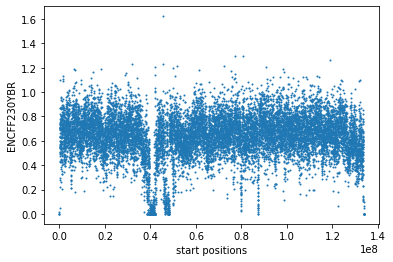

In [13]:
##visualize some of the profiles
#1
plt.scatter(df['start'], df['ENCFF230YBR'], s=1)
plt.xlabel('start positions')
plt.ylabel('ENCFF230YBR')

Text(0, 0.5, 'ENCFF953CVO')

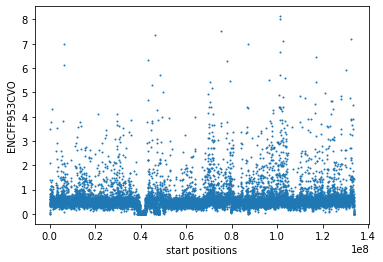

In [14]:
#2
plt.scatter(df['start'], df['ENCFF953CVO'], s=1)
plt.xlabel('start positions')
plt.ylabel('ENCFF953CVO')

Text(0, 0.5, 'ENCFF730SPR')

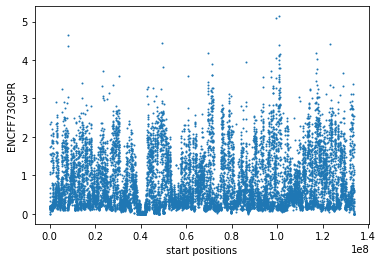

In [16]:
#3
plt.scatter(df['start'], df['ENCFF730SPR'], s=1)
plt.xlabel('start positions')
plt.ylabel('ENCFF730SPR')

**After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?**

The signals dropping indicates that there is no binding site of DNA-associated proteins. In this case, one possibility is that the centromere is located at around 40Mb since centromeres are not included in the traditional reference genome assembly. However, it is known now that the centromere of chr10 is located at 39.8Mbp. Thus, this fact further shows that many signals dip on chr10 at around 40Mb because they are at the centromere of chr10.

**Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.**

In [39]:
X = df.iloc[:,3:]
from sklearn.preprocessing import StandardScaler

#Standardize the features
scaler = StandardScaler()
scaler.fit(X)
x_scaled = scaler.transform(X)

In [43]:
from sklearn.decomposition import PCA
#Apply PCA
my_pca = PCA(n_components=2, random_state=44)
my_pca.fit(x_scaled)
x_my_pca = my_pca.transform(x_scaled)

np.cumsum(my_pca.explained_variance_ratio_ * 100)

array([33.12533558, 43.23091671])

/Users/yuqiuwang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'PC2')

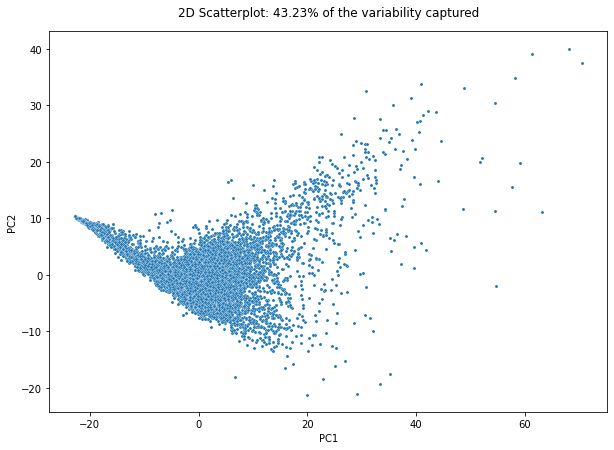

In [44]:
import seaborn as sns
#Plot the PC1 vs PC2
plt.figure(figsize=(10,7))
sns.scatterplot(x_my_pca[:,0], x_my_pca[:,1], s=10)
plt.title('2D Scatterplot: 43.23% of the variability captured', pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')

Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that sklearn.preprocessing.LabelEncoder() can be useful for transforming text strings to categories, and plt.text can be used to overlay labels with points.

trytrytry

Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.

Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.

How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that sklearn.preprocessing.StandardScaler could be useful for preprocessing.

How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot).


How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.

Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not? (No plots needed for this question).